<a href="https://colab.research.google.com/github/iammartian0/Audio101/blob/main/tts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets[audio]

In [ ]:
!pip install --upgrade evaluate jiwer


In [ ]:
!pip install accelerate -U

In [ ]:
!pip install sentencepiece

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [3]:
inputs = processor(text="Peter Piper picked a peck of pickled peppers,A peck of pickled peppers Peter Piper picked,If Peter Piper picked a peck of pickled peppers, Where's the peck of pickled peppers Peter Piper picked?", return_tensors="pt")

In [10]:
from datasets import load_dataset

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")

import torch

speaker_embeddings = torch.tensor(embeddings_dataset[5306]["xvector"]).unsqueeze(0)

In [5]:
embeddings_dataset


Dataset({
    features: ['filename', 'xvector'],
    num_rows: 7931
})

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [7]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [11]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [12]:
from IPython.display import Audio

Audio(speech, rate=16000)

In [ ]:
!nvidia-smi

Sun Jul  9 22:19:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers datasets soundfile speechbrain

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "it", split="train")
len(dataset)

In [3]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [4]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [5]:
tokenizer = processor.tokenizer

In [6]:
dataset[0]

{'audio_id': '20130522-0900-PLENARY-15-it_20130522-17:29:48_2',
 'language': 5,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/59d3156fa3afac96252c828faab59a4711c54e196e66b8774c057b01f58e999d/train_part_0/20130522-0900-PLENARY-15-it_20130522-17:29:48_2.wav',
  'array': array([0.04092407, 0.03231812, 0.037323  , ..., 0.00527954, 0.00784302,
         0.00302124]),
  'sampling_rate': 16000},
 'raw_text': "Ma quanto sarebbe utile che, recuperando i patrimoni sottratti da dittatori e da nomenclature, si creino dei fondi di sviluppo economico diffuso, del microcredito, delle agevolazioni per l'imprenditoria, delle borse di studio per gli studenti, e sarebbe il modo migliore per restituire ai cittadini quanto gli è stato sottratto e si darebbe un segnale potente di che cosa può offrire una collaborazione internazionale virtuosa.",
 'normalized_text': "ma quanto sarebbe utile che recuperando i patrimoni sottratti da dittatori e da nomenclature si creino dei fondi di 

In [7]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/22576 [00:00<?, ? examples/s]

In [8]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'è', 'ì', 'í', 'ï', 'ò', 'ó', 'ù'}

In [9]:
replacements = [
    ("à", "a"),
    ("è", "e"),
    ('ì', "i"),
    ("í", "i"),
    ("ï", "i"),
    ('ò', "o"),
    ('ó', "o"),
    ('ù', "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/22576 [00:00<?, ? examples/s]

In [10]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

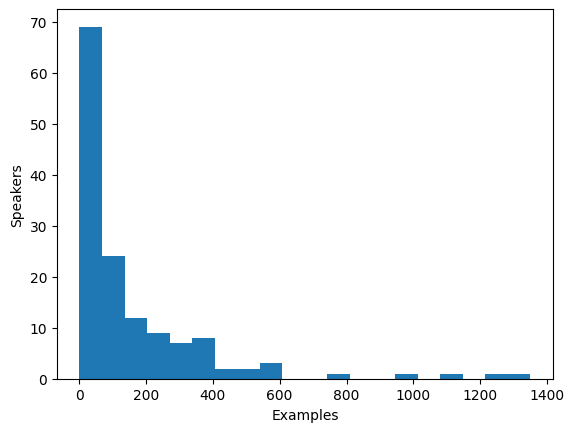

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [18]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/6186 [00:00<?, ? examples/s]

In [19]:
len(set(dataset["speaker_id"]))

37

In [20]:
len(dataset)

6186

In [21]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [22]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [23]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

/usr/local/lib/python3.10/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


['input_ids', 'labels', 'speaker_embeddings']

In [24]:
processed_example["speaker_embeddings"].shape

(512,)

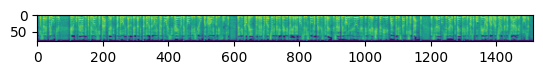

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [26]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/6186 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (684 > 600). Running this sequence through the model will result in indexing errors


In [27]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/6186 [00:00<?, ? examples/s]

3358

In [28]:
dataset = dataset.train_test_split(test_size=0.1)

In [29]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [30]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [31]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [32]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [33]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_it",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [34]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

Cloning https://huggingface.co/iammartian0/speecht5_finetuned_voxpopuli_it into local empty directory.


In [35]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.546700,0.500258
2000,0.518200,0.488248
3000,0.504600,0.485651
4000,0.501300,0.485506


TrainOutput(global_step=4000, training_loss=0.5383272769451142, metrics={'train_runtime': 10085.5325, 'train_samples_per_second': 12.691, 'train_steps_per_second': 0.397, 'total_flos': 1.870548196853952e+16, 'train_loss': 0.5383272769451142, 'epoch': 42.33})

In [36]:
kwargs = {
    "dataset_tags": "voxpopuli/it",
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
}

trainer.push_to_hub(**kwargs)

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/558M [00:00<?, ?B/s]

Upload file runs/Jul10_11-00-52_83a729ee64a6/events.out.tfevents.1688986866.83a729ee64a6.878.0:   0%|         …

To https://huggingface.co/iammartian0/speecht5_finetuned_voxpopuli_it
   d5efc30..8f7100a  main -> main

   d5efc30..8f7100a  main -> main

To https://huggingface.co/iammartian0/speecht5_finetuned_voxpopuli_it
   8f7100a..43b78d7  main -> main

   8f7100a..43b78d7  main -> main



'https://huggingface.co/iammartian0/speecht5_finetuned_voxpopuli_it/commit/8f7100a306cb32ed6a7a51f7d34d0b7702c1621f'

In [38]:
model = SpeechT5ForTextToSpeech.from_pretrained(
    "iammartian0/speecht5_finetuned_voxpopuli_it"
)

In [45]:
example = dataset["test"][104]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [46]:
text = "Ciao a tutti, sono un robot che parla italiano. La mia ragazza è molto arrabbiata"

In [47]:
inputs = processor(text=text, return_tensors="pt")

In [48]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [49]:
from IPython.display import Audio

Audio(speech.numpy(), rate=16000)